# Imports

In [20]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "team_select_poc"
os.environ['LANGCHAIN_API_KEY'] = "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"

In [21]:
from typing import Any, TypedDict, Dict, Annotated
from pydantic import BaseModel
from operator import add
from IPython.display import Image, display, Markdown
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction
from langchain_openai import ChatOpenAI

import langgraph
from langgraph.graph import StateGraph, END
from chains import get_finish_chain, get_supervisor_chain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage 


In [22]:
from tools import market_intelligence_tools
from prompts import get_market_intelligence_agent_prompt
from datetime import datetime
from llms import llm
from config import setup_environment

setup_environment()

# ALL IMPORTS
# from tools import financial_metrics_tools, news_sentiment_tools, market_intelligence_tools
# from prompts import get_financial_metrics_agent_prompt, get_news_sentiment_agent_prompt, get_market_intelligence_agent_prompt
# from sql_agent import query_database
# from datetime import datetime
# from llms import llm

def disp(text):
    display(Markdown(text))
    return

# LLM

In [23]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x108f7ce30>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x108f7e930>, root_client=<openai.OpenAI object at 0x108ea1be0>, root_async_client=<openai.AsyncOpenAI object at 0x108f7ce90>, model_name='gpt-4o-mini', temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

# Config

In [24]:
settings = {
                "model": "gpt-4o-mini",
                "temperature": 0.3,
            }

# Callbacks

In [25]:
class CustomConsoleCallbackHandler(BaseCallbackHandler):
    def __init__(self):
        """Initialize the handler"""
        self.current_agent_name = None
        super().__init__()

    def write_agent_name(self, name: str):
        """Display agent name"""
        self.current_agent_name = name
        print(f"\n=== Agent: {name} ===")

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        """Display tool execution start"""
        print(f"\n🔧 Using tool: {serialized['name']}")

    def on_tool_end(self, output: str, **kwargs):
        """Display tool execution result"""
        print("\n📤 Tool output:")
        print("-" * 50)
        print(output)
        print("-" * 50)

    def on_agent_action(self, action: AgentAction, **kwargs):
        """Display agent action"""
        print(f"\n🎯 Action: {action.tool}")
        print("Input:")
        print("-" * 50)
        print(action.tool_input)
        print("-" * 50)

    def on_llm_start(self, serialized: Dict[str, Any], prompts: list[str], **kwargs):
        """Display when LLM starts processing"""
        print("\n🤔 Processing...")

    def on_llm_end(self, response, **kwargs):
        """Display final LLM response"""
        if hasattr(response, 'generations') and response.generations:
            print("\n Final LLM Response:")
            print("-" * 50)
            print(response.generations[0][0].text)
            print("-" * 50)

    def on_tool_error(self, error: str, **kwargs):
        """Display tool errors"""
        print(f"\n❌ Error: {error}")

# States

### Market Intelligence Agent Internal State

In [26]:
class TopicAdherenceEval(BaseModel):
    passed: Annotated[list[Any] , add] # will hold values of True or False
    reason: Annotated[list[Any] , add] # will hold reasons for the True or False

# Add state for all_tools_called_eval
class AllToolsEval(BaseModel):
    passed: Annotated[list[Any], add]  # bool value for if evalution passed = all tools were called successfully
    stats: Annotated[list[Any] , add]  # stats for each tool call, errors etc..
    
# Pydantic structure for model to evaluate response:
class LLM_TopicAdherenceEval(BaseModel):
    passed: str
    reason: str

# INTERNAL STATES FROM OTHER AGENTS
class SentimentNewsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    
    topic_adherence_eval: TopicAdherenceEval        

class FinancialMetricsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                   
    topic_adherence_eval: TopicAdherenceEval        




### Market Intelligence Agent Internal State

In [27]:
class MarketIntelligenceState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    # Annotated[list[Any], add]
    topic_adherence_eval: TopicAdherenceEval        # Annotated[list[TopicAdherenceEval] , add]


### Overall State

In [28]:
from personality import AgentPersonality

# Personality - default
sample_personality = AgentPersonality()
    
# OVERALL AGENT STATE
class AgentState(TypedDict):
    current_date: datetime
    user_input: str
    messages: list[BaseMessage]
    next_step: str
    config: dict
    callback: Any
    personality: AgentPersonality
    news_sentiment_agent_internal_state: SentimentNewsState
    financial_metrics_agent_internal_state: FinancialMetricsState
    market_intelligence_agent_internal_state: MarketIntelligenceState

# sample state:
# state = {   
#     "current_date": datetime.now(),
#     "messages": list(message_history.messages) + [prompt],
#     "user_input": prompt,
#     "config": settings,
#     "callback": callback_handler,
#     "personality": sample_personality
# }


# Helper Functions

In [29]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str, max_iterations: int = 2,  return_intermediate_steps: bool = True) -> AgentExecutor:
    """
    Creates an agent using the specified ChatOpenAI model, tools, and system prompt.

    Args:
        llm : LLM to be used to create the agent.
        tools (list): The list of tools to be given to the worker node.
        system_prompt (str): The system prompt to be used in the agent.

    Returns:
        AgentExecutor: The executor for the created agent.
    """
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, max_iterations = max_iterations, return_intermediate_steps = return_intermediate_steps, verbose = True)
    return executor

**GET TOOLS CALL EVAL STATS**

In [30]:
def get_tools_call_eval_stats(result: Dict):
    """Helper function to format the output and store evaluation stats"""
    print("\n📊 TOOL EVALUATION SUMMARY")
    print("=" * 50)
    
    # Create stats dictionary to store in state
    run_stats = {
        "timestamp": datetime.now(),
        "all_tools_used": result["all_tools_used"],
        "tool_counts": result['tool_usage']['call_counts'],
        "errors": {
            "invalid_tools": result['tool_usage']['errors']['invalid_tools'],
            "execution_errors": result['tool_usage']['errors']['execution_errors'],
            "parser_errors": result['tool_usage']['errors']['parser_errors']
        }
    }
    
    # Print evaluation results
    all_tools_status = "✅" if result["all_tools_used"] else "❌"
    print(f"\n🎯 Overall Status:")
    print(f"  • All Required Tools Used: {all_tools_status}")
    
    print(f"\n📋 Tool Inventory:")
    print(f"  • Available Tools: {', '.join(result['tool_usage']['available_tools'])}")
    print(f"  • Successfully Used: {', '.join(result['tool_usage']['used_tools'])}")
    print(f"  • Not Used: {', '.join(result['tool_usage']['unused_tools'])}")
    
    print("\n📈 Usage Statistics:")
    for tool, count in result['tool_usage']['call_counts'].items():
        status = "✅" if count > 0 else "❌"
        print(f"  {status} {tool}: {count} calls")
    
    # Error Summary
    has_errors = any(len(errs) > 0 for errs in result['tool_usage']['errors'].values())
    if has_errors:
        print("\n⚠️ Error Summary:")
        errors = result['tool_usage']['errors']
        
        if errors['invalid_tools']:
            print("\n  Invalid Tool Attempts:")
            for err in errors['invalid_tools']:
                print(f"  • Requested: {err['requested']}")
                print(f"    Available: {', '.join(err['available'])}")
        
        if errors['execution_errors']:
            print("\n  Tool Execution Errors:")
            for err in errors['execution_errors']:
                print(f"  • Tool: {err['tool']}")
                print(f"    Input: {err['input']}")
                print(f"    Error: {err['error']}")
        
        if errors['parser_errors']:
            print("\n  Parser Errors:")
            for err in errors['parser_errors']:
                print(f"  • Input: {err['input']}")
                print(f"    Error: {err['error']}")
    
    print("\n🔍 Detailed Tool Execution Log:")
    for step in result["tools_used"]:
        status_emoji = {
            "success": "✅",
            "parser_error": "🔍",
            "invalid_tool": "❌",
            "execution_error": "⚠️"
        }.get(step['status'], "❓")
        
        print(f"\n  {status_emoji} Tool: {step['tool']}")
        print(f"    Status: {step['status']}")
        print(f"    Input: {step['input']}")
        if step['status'] == "success":
            print(f"    Output: {str(step['output'])[:100]}...")  # Truncate long outputs
    
    print("\n" + "=" * 50)
    
    return run_stats

# PROMPTS

In [31]:
TOPIC_ADHERENCE_PROMPT = """You are a specialized evaluator assessing the relevance and comprehensiveness of responses from the Market Intelligence Agent.

The Market Intelligence Agent is designed to provide:
- Technical analysis (price patterns, trends, support/resistance levels)
- Insider trading activity and patterns
- Market dynamics (volume, volatility, momentum)
- Trading signals and indicators (RSI, MACD, moving averages)

The user asked:
{question}

The Agent responded with:
{answer}

Evaluate if the answer effectively addresses the user's question by providing relevant market analysis and intelligence.

Your response must be valid JSON matching this exact format:
{{
    "passed": "true" or "false", 
    "reason": "Brief explanation of your evaluation"
}}

Guidelines for evaluation:
- "passed" should be "true" if the answer:
  * Directly addresses the main points of the question
  * Includes relevant technical indicators and patterns
  * Analyzes insider trading activity when applicable
  * Uses market data and trading signals to support analysis

- "passed" should be "false" if the answer:
  * Is off-topic or misses the core question
  * Lacks key technical analysis or market indicators
  * Fails to include relevant trading patterns or signals
  * Provides incomplete or superficial market analysis

- The "reason" should specifically explain how well the response incorporated technical analysis, insider trading patterns, market dynamics, and trading signals in addressing the query
"""

# NODES

In [32]:
market_intelligence_tools

[StructuredTool(name='get_insider_transactions', description='Fetch and summarize insider transactions for a given stock symbol.', args_schema=<class 'langchain_core.utils.pydantic.get_insider_transactions'>, func=<function get_insider_transactions at 0x11ad0a340>),
 StructuredTool(name='get_stock_aggregates', description="Fetch aggregate bars (OHLCV) for a stock over a given date range with custom time windows.\n\nArgs:\n    symbol (str): Stock ticker symbol (e.g., 'AAPL')\n    multiplier (int): Size of the timespan multiplier (e.g., 1, 2, 5)\n    timespan (str): Size of the time window ('minute', 'hour', 'day', 'week', 'month', 'quarter', 'year')\n    from_date (str): Start date in YYYY-MM-DD format\n    to_date (str): End date in YYYY-MM-DD format\n    adjusted (bool): Whether to adjust for splits\n    sort (str): Sort direction ('asc' or 'desc')\n    limit (int): Number of results (max 50000)\n\nReturns:\n    dict: Aggregated stock data including OHLCV values", args_schema=<class '

In [33]:
def market_intelligence_node(state):
    """
    Handles market data analysis using tools from tools.py
    """
    print("\n" + "-"*50)
    print("📈 MARKET INTELLIGENCE NODE")
    
    market_agent = create_agent(
        llm,
        market_intelligence_tools,
        get_market_intelligence_agent_prompt(state.get("current_date"), state.get("personality"), state.get("user_input"))
    )
    
    state["callback"].write_agent_name("Market Intelligence Agent 📈")
    output = market_agent.invoke(
        {"messages": state["messages"]}, {"callbacks": [state["callback"]]} , return_intermediate_steps = True )
    print(f"Analysis complete - Output length: {len(output.get('output', ''))}")
    
    state["messages"].append(
        HumanMessage(content=output.get("output"), name="MarketIntelligence")
    )

    # ADDED: financial_metrics_agent tools:
    available_tools = {tool.name: 0 for tool in market_agent.tools}                                           
    state["market_intelligence_agent_internal_state"]["agent_executor_tools"] = available_tools
    state["market_intelligence_agent_internal_state"]["full_response"] = output # output contains all the messages


    print("-"*50 + "\n")
    return state


# Evaluate all tools called:
def evaluate_all_tools_called(state):
    """Evaluates tool usage and stores statistics in state"""
    sample_response = state['market_intelligence_agent_internal_state']
    print("INSIDE EVALUATE ALL TOOLS CALLED: ", sample_response)
    
    # This dictionary will be used for later evaluation statistics
    result = {
        "answer": sample_response['full_response']["output"],
        "tools_used": [],
        "all_tools_used": False,
        "tool_usage": {
            "available_tools": list(sample_response['agent_executor_tools'].keys()),
            "used_tools": set(),
            "unused_tools": set(),
            "call_counts": sample_response['agent_executor_tools'].copy(),
            "errors": {
                "invalid_tools": [],
                "execution_errors": [],
                "parser_errors": []
            }
        }
    }

    # Process intermediate steps
    for action, observation in sample_response['full_response']["intermediate_steps"]:
        # print( 'ACTION: ', action)
        # print(' OBSERVATION: ', observation)
        tool_name = action.tool
        tool_input = action.tool_input
        
        # Determine status based on observation
        status = "success"  # Default, but will be immediately evaluated
        
        if tool_name == "_Exception":
            status = "parser_error"
            result["tool_usage"]["errors"]["parser_errors"].append({
                "input": tool_input,
                "error": observation
            })
        elif isinstance(observation, dict) and "requested_tool_name" in observation:
            status = "invalid_tool"
            result["tool_usage"]["errors"]["invalid_tools"].append({
                "requested": tool_name,
                "available": observation.get("available_tool_names", [])
            })
        elif isinstance(observation, dict) and next(iter(observation), "").lower().startswith("error"):
            
            status = "execution_error"
            result["tool_usage"]["errors"]["execution_errors"].append({
                "tool": tool_name,
                "input": tool_input,
                "error": observation
            })

        tool_result = {
            "tool": tool_name,
            "input": tool_input,
            "output": observation,
            "status": status
        }
        
        # Only count successful executions in usage statistics
        if status == "success":
            result["tool_usage"]["used_tools"].add(tool_name)
            result["tool_usage"]["call_counts"][tool_name] += 1

        result["tools_used"].append(tool_result)

    # Calculate unused tools
    
    # Set of tool names (strings) that were available but not used
    result["tool_usage"]["unused_tools"] = set(result["tool_usage"]["available_tools"]) - result["tool_usage"]["used_tools"]
    result["all_tools_used"] = len(result["tool_usage"]["unused_tools"]) == 0

    # Store evaluation stats in state
    run_stats = get_tools_call_eval_stats(result)
    
    # Initialize all_tools_eval if needed
    if 'stats' not in state['market_intelligence_agent_internal_state']['all_tools_eval']:
        state['market_intelligence_agent_internal_state']['all_tools_eval'] = {
            'stats': [],
            'passed': []
        }
    
    # Append new stats and pass/fail status
    state['market_intelligence_agent_internal_state']['all_tools_eval']['stats'].append(run_stats)
    state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'].append(result["all_tools_used"])
    
    return state
# Evaluate Topic Adherence
def evaluate_topic_adherence(state):
    print(' INSIDE evaluate_topic_adherence')
    messages = [
        SystemMessage(content=TOPIC_ADHERENCE_PROMPT.format(
            question=state['user_input'],
            answer= state['market_intelligence_agent_internal_state']['full_response']['output']
        ))
    ]
    llm_evaluator = llm.with_structured_output(LLM_TopicAdherenceEval)
    response = llm_evaluator.invoke(messages)
    
    # Append to the internal state:
    state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed'].append(response.passed)
    state['market_intelligence_agent_internal_state']['topic_adherence_eval']['reason'].append(response.reason)
    return state

# EDGES

In [34]:
def execute_again_all_tools_called(state):
    print("INSIDE execute_again_all_tools_called")
    # all_tools_called_eval_passed will contain a booleean
    passed = state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'][-1]
    iterations = len(state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'])
    print("passed value:" ,passed )
    print('iterations: ', iterations, 'values: ' , state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'])

    if passed or iterations >= 2:
        return "EvaluateTopicAdherence"
    else:
        print('GO BACK TO THE AGENT, tools not passed')
        return "MarketIntelligenceAgent"

def execute_again_topic_adherence(state):
    print('INSIDE execute_again_topic_adherence')
    
    # Check if 'topic_adherence_eval' has any evaluations
    if not state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed']:
        print("No topic adherence evaluations found.")
        return "MarketIntelligenceAgent"  
    
    # Access the latest evaluation
    last_passed = state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed'][-1].lower()
    # Check how many evaluations occured
    iterations = len(state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed'])
    
    print("TOPIC ADHERENCE EVALUATION PASSED:", last_passed)
    print("NUMBER OF ITERATIONS FOR TOPIC ADHERENCE:", iterations)

    if last_passed == "true" or iterations >= 2: 
        print(f'ENDING! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "end"
    else:
        print(f'RETURN TO AGENT, adherence failed! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "MarketIntelligenceAgent"

# Define and Build the Graph

In [35]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("MarketIntelligenceAgent", market_intelligence_node)
    workflow.add_node("EvaluateAllToolsCalled", evaluate_all_tools_called)
    workflow.add_node("EvaluateTopicAdherence", evaluate_topic_adherence)
    
    # Set entry point
    workflow.set_entry_point("MarketIntelligenceAgent")
    
    # Add edges
    workflow.add_edge("MarketIntelligenceAgent", "EvaluateAllToolsCalled")
    
    workflow.add_conditional_edges("EvaluateAllToolsCalled", execute_again_all_tools_called, 
    {
        "EvaluateTopicAdherence": "EvaluateTopicAdherence", 
        "MarketIntelligenceAgent": "MarketIntelligenceAgent"
    }
      )
    
    workflow.add_conditional_edges("EvaluateTopicAdherence", execute_again_topic_adherence,                           
    {
        "end": END, 
        "MarketIntelligenceAgent": "MarketIntelligenceAgent"
    }
      )
                            
    return workflow.compile()

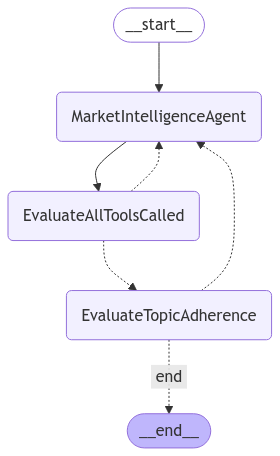

In [36]:
graph = define_graph()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

# Test the Agent

In [37]:
def test_agent(agent: langgraph.graph.state.CompiledStateGraph, question: str, verbose: bool = True):
    """Run a test query through the agent"""
    callback_handler = CustomConsoleCallbackHandler()
    # callback.verbose = verbose
   
    initial_state = {
        "current_date": datetime.now(),
        "user_input": question,
        "messages": [],
        "next_step": "",
        "config": settings,
        "callback": callback_handler,
        "personality": sample_personality,
        "news_sentiment_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        "financial_metrics_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        "market_intelligence_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        }
    }
    # Run the agent
    response = graph.invoke(initial_state)
    
    return response

In [38]:
response = test_agent(graph , "what are the trends for ethereum for 2025", verbose = False)


--------------------------------------------------
📈 MARKET INTELLIGENCE NODE

=== Agent: Market Intelligence Agent 📈 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: get_insider_transactions
Input:
--------------------------------------------------
{'symbol': 'ETH'}
--------------------------------------------------

Invoking: `get_insider_transactions` with `{'symbol': 'ETH'}`



🔧 Using tool: get_insider_transactions

📤 Tool output:
--------------------------------------------------
{'message': 'No significant insider transactions found in the recent data.', 'transaction_summary': {'total_buys': 0, 'total_sells': 0, 'total_buy_value': 0, 'total_sell_value': 0, 'net_transaction_value': 0}}
--------------------------------------------------
{'message': 'No significant insider transactions found in the recent data.', 'transaction_summary':

In [ ]:
disp(response["market_intelligence_agent_internal_state"]["full_response"]["output"])

In [39]:
response = test_agent(graph , "Should I buy stocks from the company called Quantum Computing Inc?", verbose = False)


--------------------------------------------------
📈 MARKET INTELLIGENCE NODE

=== Agent: Market Intelligence Agent 📈 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: get_insider_transactions
Input:
--------------------------------------------------
{'symbol': 'QUBT'}
--------------------------------------------------

Invoking: `get_insider_transactions` with `{'symbol': 'QUBT'}`



🔧 Using tool: get_insider_transactions

📤 Tool output:
--------------------------------------------------
{'message': 'No significant insider transactions found in the recent data.', 'transaction_summary': {'total_buys': 0, 'total_sells': 0, 'total_buy_value': 0, 'total_sell_value': 0, 'net_transaction_value': 0}}
--------------------------------------------------
{'message': 'No significant insider transactions found in the recent data.', 'transaction_summary

In [40]:
disp(response["market_intelligence_agent_internal_state"]["full_response"]["output"])

```
Market Intelligence Report:
1. Data Context:
   - Analysis Date: 2024-11-24
   - Latest Trading Data Available: 2024-11-23
   - Time Periods Analyzed: 
     - Daily: November 1, 2024 - November 23, 2024
     - Weekly: September 1, 2024 - November 23, 2024
     - Monthly: November 1, 2023 - November 23, 2024

2. Technical Analysis:
   - **Price Trend Analysis**: 
     - The stock price of Quantum Computing Inc (QUBT) has shown significant volatility over the analyzed periods. The price surged from around $1.11 at the beginning of November to a high of $6.10 by mid-November, indicating a strong upward trend followed by some consolidation.
   - **Volume Patterns**: 
     - Trading volume has been exceptionally high, particularly during the price surge, with notable spikes on days when the price reached its peak. For instance, on November 15, the volume reached over 395 million shares, indicating strong investor interest.
   - **Technical Indicators**: 
     - Moving averages indicate a bullish trend, with the short-term moving average crossing above the long-term moving average.
   - **Support/Resistance Levels**: 
     - Immediate support is observed around $4.00, while resistance levels are noted around $6.00, which may act as a barrier for further upward movement.
   - **Volatility Metrics**: 
     - The stock has exhibited high volatility, typical for growth stocks in emerging sectors like quantum computing, which can lead to both opportunities and risks.

3. Insider Activity:
   - **Recent Transactions**: 
     - No significant insider transactions were found in the recent data, indicating a lack of insider buying or selling activity that could signal confidence or concern from company executives.
   - **Buy/Sell Patterns**: 
     - With no transactions reported, there are no patterns to analyze, which may suggest a wait-and-see approach from insiders.
   - **Key Insider Moves**: 
     - No key insider moves were identified, which could be a point of concern for potential investors looking for insider confidence.
   - **Transaction Timing**: 
     - The absence of transactions makes it difficult to assess timing patterns or insider sentiment.
   - **Historical Context**: 
     - Historically, insider buying can be a bullish signal; however, the lack of activity may not necessarily indicate negative sentiment.

4. Market Context:
   - **Sector Position**: 
     - Quantum Computing Inc operates in a rapidly evolving sector with significant growth potential. However, it also faces competition and market volatility.
   - **Relative Performance**: 
     - Compared to broader market indices, QUBT has outperformed in recent weeks, particularly during the price surge.
   - **Risk Indicators**: 
     - High volatility and lack of insider transactions may pose risks, especially for moderate-risk investors.
   - **Market Cycle Stage**: 
     - The stock appears to be in a growth phase, but caution is warranted due to potential corrections following rapid price increases.

5. Trading Implications:
   - **Entry/Exit Points**: 
     - Consider entering around the support level of $4.00 if the price stabilizes, with an exit strategy near the resistance level of $6.00.
   - **Position Sizing**: 
     - Given the moderate risk tolerance, a smaller position size may be prudent to manage exposure.
   - **Risk Parameters**: 
     - Set stop-loss orders below the support level to protect against downside risk.
   - **Time Horizon**: 
     - Align trading strategies with a medium-term horizon, monitoring for signs of consolidation or further upward momentum.
   - **Monitoring Triggers**: 
     - Keep an eye on trading volume and any future insider transactions, as these could provide insights into market sentiment and potential price movements.
```

questions for reetu:

- Track and analyze insider buying/selling patterns
    how is it tracking and analyzing? who are these insiders?
- can we think of other evaluation metrics?
- we need to update the SQL db, do we really need the information from this db?

# EXAMPLE OF EVALUATION:

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

In [42]:
# evaluation details will be found here:
all_tools_eval_results =response['market_intelligence_agent_internal_state']['all_tools_eval']
topic_adherence_eval_results =response['market_intelligence_agent_internal_state']['topic_adherence_eval']

## **All tools called analysis**

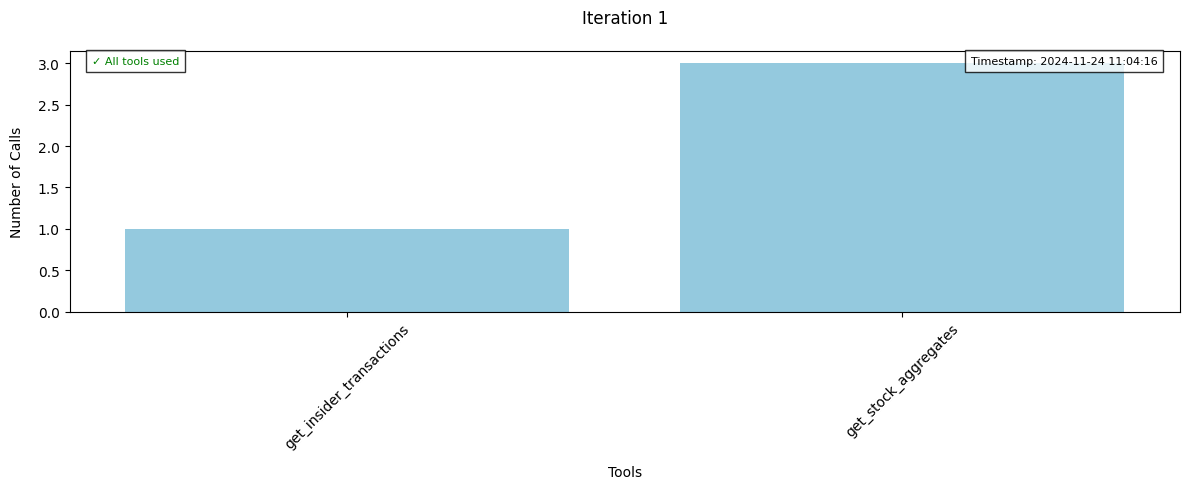

In [43]:
# Calculate number of iterations and set up the subplots
n_iterations = len(all_tools_eval_results['stats'])
fig, axes = plt.subplots(n_iterations, 1, figsize=(12, 5*n_iterations))
if n_iterations == 1:
    axes = [axes]  # Convert to list for consistent indexing

# Process each iteration
for iteration_idx, (ax, iteration_stats) in enumerate(zip(axes, all_tools_eval_results['stats'])):
    # Create DataFrame for this iteration
    tool_counts = iteration_stats['tool_counts']
    
    # Create a mapping of tools to their error messages
    error_messages = {}
    for error in iteration_stats['errors']['execution_errors']:
        tool = error['tool']
        error_msg = error['error'].get('error', str(error['error']))
        error_messages[tool] = error_msg
    
    # Create DataFrame for this iteration
    iteration_data = []
    for tool, count in tool_counts.items():
        has_error = tool in error_messages
        iteration_data.append({
            'Tool': tool,
            'Calls': count,
            'Has Error': has_error,
            'Error Message': error_messages.get(tool, 'No error')
        })
    
    df = pd.DataFrame(iteration_data)
    
    # Create bar plot for this iteration
    sns.barplot(
        data=df,
        x='Tool',
        y='Calls',
        ax=ax,
        color='skyblue'
    )
    
    # Add error markers and annotations
    for idx, row in df.iterrows():
        if row['Has Error']:
            # Plot red X
            ax.plot(
                idx,
                row['Calls'],
                'rx',
                markersize=10,
                markeredgewidth=2,
                label='Error'
            )
            
            # Add error message annotation
            ax.annotate(
                f"Error: {row['Error Message']}",
                xy=(idx, row['Calls']),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                fontsize=8,
                wrap=True
            )
        
        # Add annotation for zero calls
        if row['Calls'] == 0:
            ax.annotate(
                'Not Called',
                xy=(idx, 0),
                xytext=(0, -20),
                textcoords='offset points',
                ha='center',
                va='top',
                color='red',
                fontsize=8
            )
    
    # Customize subplot
    ax.set_title(f'Iteration {iteration_idx + 1}', pad=20, size=12)
    ax.set_xlabel('Tools', labelpad=10)
    ax.set_ylabel('Number of Calls', labelpad=10)
    ax.tick_params(axis='x', rotation=45)
    
    # Add timestamp
    timestamp = iteration_stats['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
    ax.text(0.98, 0.98, f'Timestamp: {timestamp}', 
            transform=ax.transAxes, 
            ha='right', 
            va='top', 
            fontsize=8, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Add all_tools_used status
    status_text = "✓ All tools used" if iteration_stats['all_tools_used'] else "✗ Not all tools used"
    ax.text(0.02, 0.98, status_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=8,
            color='green' if iteration_stats['all_tools_used'] else 'red',
            bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.show()

## **Topic Adherence Eval**

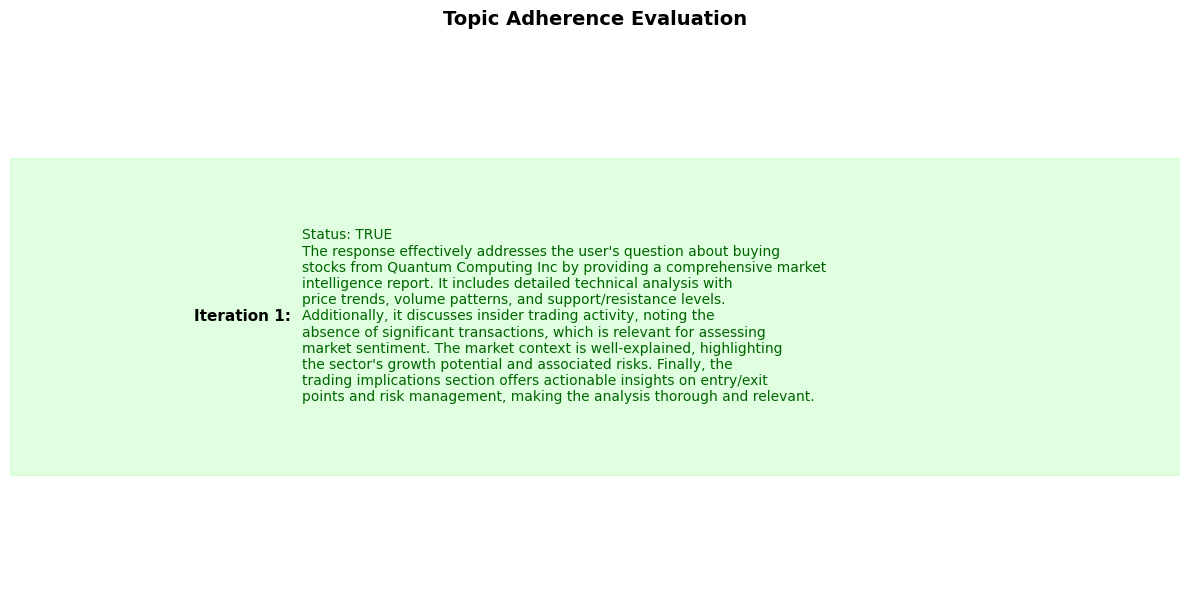

In [44]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create data for visualization
iterations = len(topic_adherence_eval_results['passed'])
y_positions = range(iterations)

# Add background colors for each iteration (adjusted height)
for i, status in enumerate(topic_adherence_eval_results['passed']):
    color = '#ff9999' if status.lower() == 'false' else '#99ff99'
    # Extend the background to fully include the iteration label
    ax.axhspan(i-0.3, i+0.3, color=color, alpha=0.3)

# Add iteration numbers and evaluation details
for i, (status, reason) in enumerate(zip(topic_adherence_eval_results['passed'], 
                                       topic_adherence_eval_results['reason'])):
    # Move iteration number inside the colored background
    ax.text(0.02, i, f'Iteration {i+1}:', 
            ha='left', va='center',
            fontsize=11, fontweight='bold')
    
    # Format the reason text (wrap at 70 characters)
    wrapped_reason = '\n'.join(wrap(reason, width=70))
    
    # Create display text with status and reason (moved right to accommodate iteration number)
    display_text = f"Status: {status.upper()}\n{wrapped_reason}"
    
    ax.text(0.15, i, display_text,
            ha='left', va='center',
            fontsize=10,
            color='darkred' if status.lower() == 'false' else 'darkgreen')

# Customize plot
ax.set_title('Topic Adherence Evaluation', pad=20, fontsize=14, fontweight='bold')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.5, iterations-0.5)

# Remove axes and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a light grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## **SUMMARY OF THE RUN**

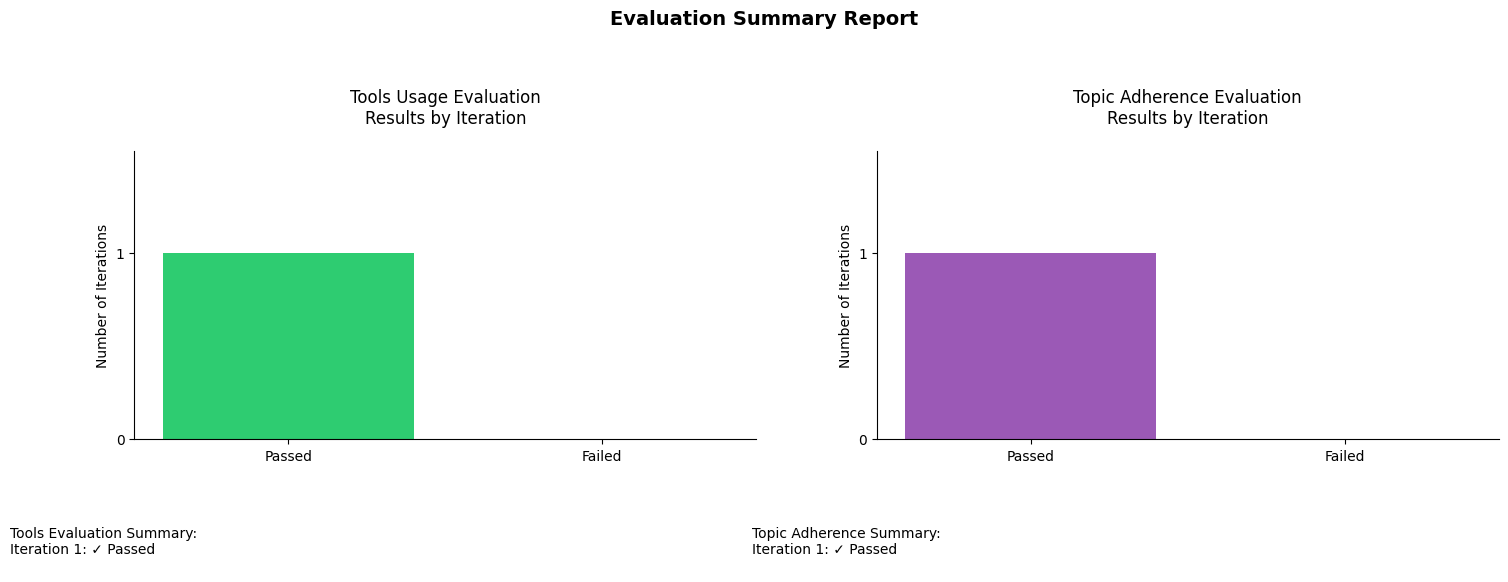

In [45]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Tools Evaluation Summary (Left Plot) ---
tools_results = all_tools_eval_results['passed']
tools_stats = {
    'Passed': sum(tools_results),
    'Failed': len(tools_results) - sum(tools_results)
}

# Create summary text for tools
tools_summary = "Tools Evaluation Summary:\n"
for i, passed in enumerate(tools_results):
    status = "✓ Passed" if passed else "✗ Failed"
    tools_summary += f"Iteration {i+1}: {status}\n"

# Plot tools results with blue palette
ax1.bar(['Passed', 'Failed'], 
        [tools_stats['Passed'], tools_stats['Failed']], 
        color=['#2ecc71', '#3498db'])  # Green and Blue
ax1.set_title('Tools Usage Evaluation\nResults by Iteration', pad=20)
ax1.text(-0.2, -0.3, tools_summary, 
         transform=ax1.transAxes, 
         verticalalignment='top',
         fontsize=10)

# --- Topic Adherence Summary (Right Plot) ---
topic_results = [status.lower() == 'true' for status in topic_adherence_eval_results['passed']]
topic_stats = {
    'Passed': sum(topic_results),
    'Failed': len(topic_results) - sum(topic_results)
}

# Create summary text for topic adherence
topic_summary = "Topic Adherence Summary:\n"
for i, status in enumerate(topic_adherence_eval_results['passed']):
    status_text = "✓ Passed" if status.lower() == 'true' else "✗ Failed"
    topic_summary += f"Iteration {i+1}: {status_text}\n"

# Plot topic adherence results with purple palette
ax2.bar(['Passed', 'Failed'], 
        [topic_stats['Passed'], topic_stats['Failed']], 
        color=['#9b59b6', '#e74c3c'])  # Purple and Red
ax2.set_title('Topic Adherence Evaluation\nResults by Iteration', pad=20)
ax2.text(-0.2, -0.3, topic_summary, 
         transform=ax2.transAxes, 
         verticalalignment='top',
         fontsize=10)

# Customize both plots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Number of Iterations')
    
    # Set y-axis to integers
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Set y-axis limits based on max value
    max_val = max([val for val in ax.get_ylim()])
    ax.set_ylim(0, max_val + 0.5)  # Add some padding at the top
    
# Add overall title
fig.suptitle('Evaluation Summary Report', fontsize=14, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

- add percentage tool call
- optimize which tools to be called.
-- for input, is this tool call appropriate?
- evaluate decision of the supervisor
- is the planner planning correctly
